# **Problem statement:**

 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**1. Data Reading/Data Understanding:** Defining the path for train and test images

In [1]:
import pathlib

# Defining the path for train and test images

data_dir_train = pathlib.Path(
    "Skin cancer ISIC The International Skin Imaging Collaboration\Train"
)
data_dir_test = pathlib.Path(
    "Skin cancer ISIC The International Skin Imaging Collaboration\Test"
)

In [2]:
# Importing libraries

import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np, pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Retrieve number of images present in train dataset
img_count_train = len(list(data_dir_train.glob("*/*.jpg")))
print(img_count_train)

# Retrieve number of images present in test dataset
img_count_test = len(list(data_dir_test.glob("*/*.jpg")))
print(img_count_test)

2239
118


**2. Dataset Creation:** Creating train & validation dataset from the train directory with a batch size of 32. Also, making sure to resize images to 180*180.

In [4]:
# Defining parameters

batch_size = 32
img_height = 180
img_width = 180

In [5]:
# Training data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [6]:
# Validation data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


**3. Dataset visualisation:** Visualizing one instance of all the nine classes present in the dataset

In [7]:
# Listing all the 9 classes

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


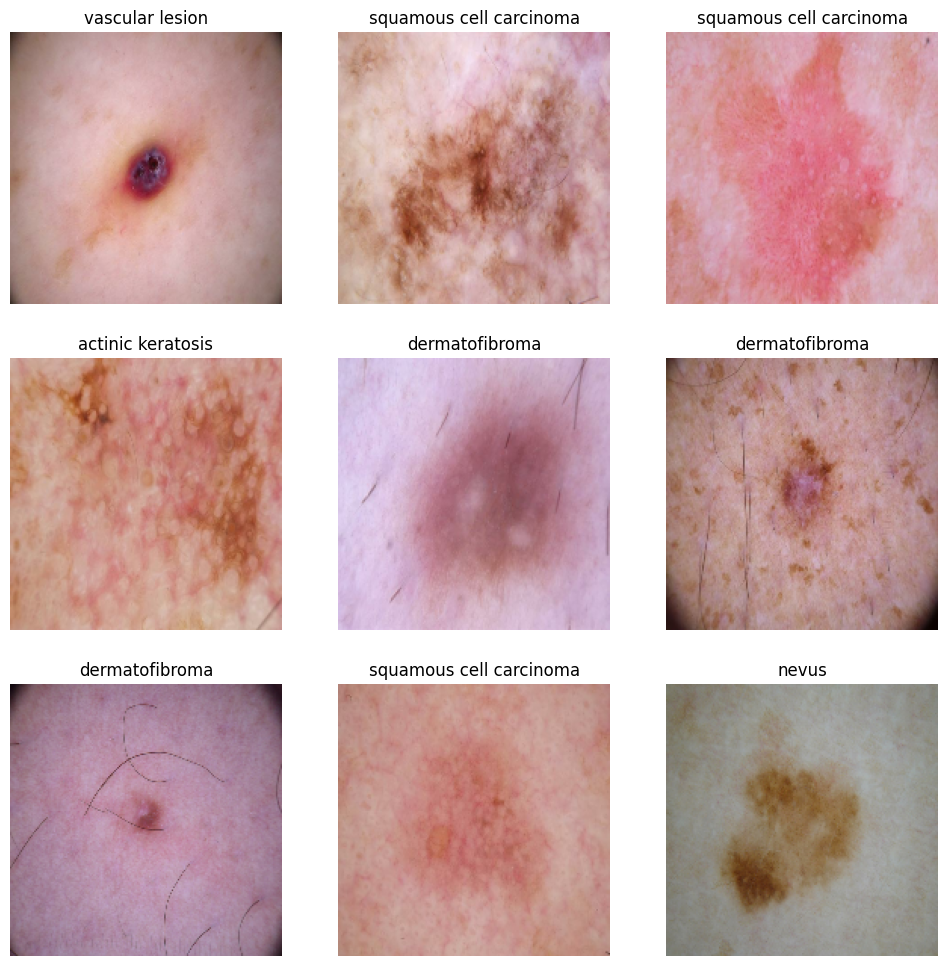

In [8]:
# Visualizing classes

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))

Insights: The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [9]:
# cache() keeps the images in memory after they're loaded off disk during the first epoch.
# prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**4. Model Building & training:**

**Model 1**

In [12]:
classes = 9

model1 = Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(classes),
    ]
)

# Choosing an appropirate optimiser and loss function
model1.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

c:\Users\govin\Desktop\Melanoma Detection Assignment\venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Viewing the summary of model
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training the model for ~20 epochs
epochs = 20

history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.2383 - loss: 1.9804 - val_accuracy: 0.4602 - val_loss: 1.3969
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step - accuracy: 0.5086 - loss: 1.2975 - val_accuracy: 0.5323 - val_loss: 1.2677
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 31s 111ms/step - accuracy: 0.6002 - loss: 1.0709 - val_accuracy: 0.6435 - val_loss: 0.9864
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7075 - loss: 0.8062

In [14]:
# Define function to visualize results
def results(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

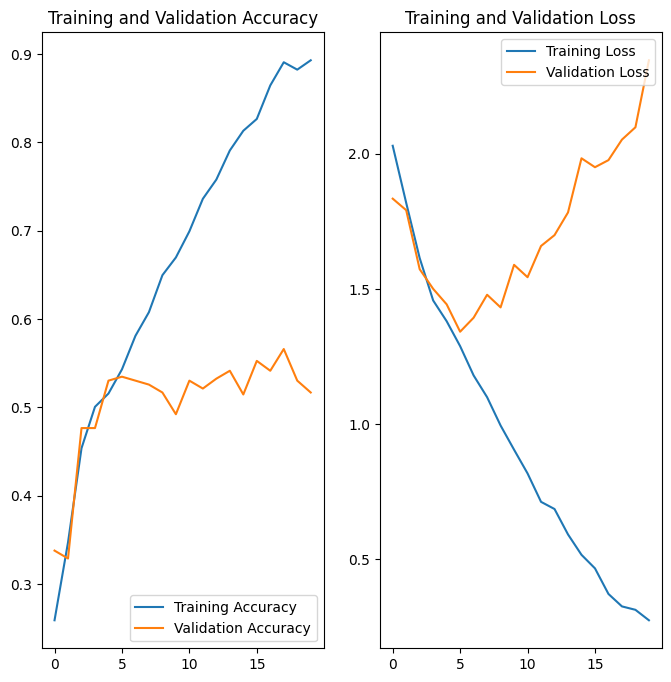

In [15]:
results(history)

The graph shows that training accuracy is much higher than validation accuracy. Around the 19th and 20th epochs, we can also notice differences in loss functions in training and validation data. This is a clear instance of overfitting, in which the model learnt too much from the training dataset and is unable to perform well on the validation dataset.

**Training Accuracy:** 89.290 &
**Validation Accuracy:** 51.68

**5. Model Building & training on the augmented data :**

**Model 2**

In [16]:
# Data Augumentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(img_height, img_width, 3)
        ),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [17]:
# Using Dropout layer for handling overfitting

model2 = Sequential(
    [
        data_augmentation,
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(classes),
    ]
)

model2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [18]:
# Viewing the summary of model
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [19]:
# Training the model for ~20 epochs
epochs = 20

history_1 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 95s 2s/step - loss: 1.9916 - accuracy: 0.2634 - val_loss: 1.7972 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 98s 2s/step - loss: 1.7167 - accuracy: 0.3990 - val_loss: 1.6101 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 90s 2s/step - loss: 1.5590 - accuracy: 0.4448 - val_loss: 1.4800 - val_accuracy: 0.4966
Epoch 4/20
56/56 [==============================] - 91s 2s/step - loss: 1.4779 - accuracy: 0.4660 - val_loss: 1.4521 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 85s 2s/step - loss: 1.4247 - accuracy: 0.5006 - val_loss: 1.3916 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 87s 2s/step - loss: 1.3481 - accuracy: 0.5285 - val_loss: 1.3767 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 90s 2s/step - loss: 1.3631 - accuracy: 0.5301 - val_loss: 1.4146 - val_accuracy: 0.5235
Epoch 8/20
56/56 [==

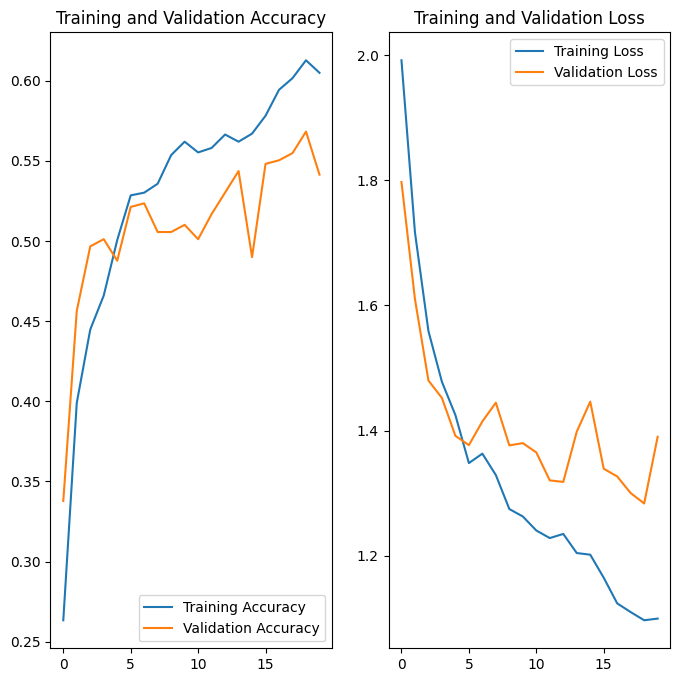

In [20]:
results(history_1)

Training accuracy has not increased when compared to the basic model, however the gap between training and validation accuracy has narrowed. In addition, validation accuracy is marginally improved over the original model. The gap between training loss and validation loss is also narrowed. And we see that overfitting has been decreased as a result of data augmentation.

**Training Accuracy:** 60.49 &
**Validation Accuracy:** 54.14

**6. Class distribution:**

<BarContainer object of 9 artists>

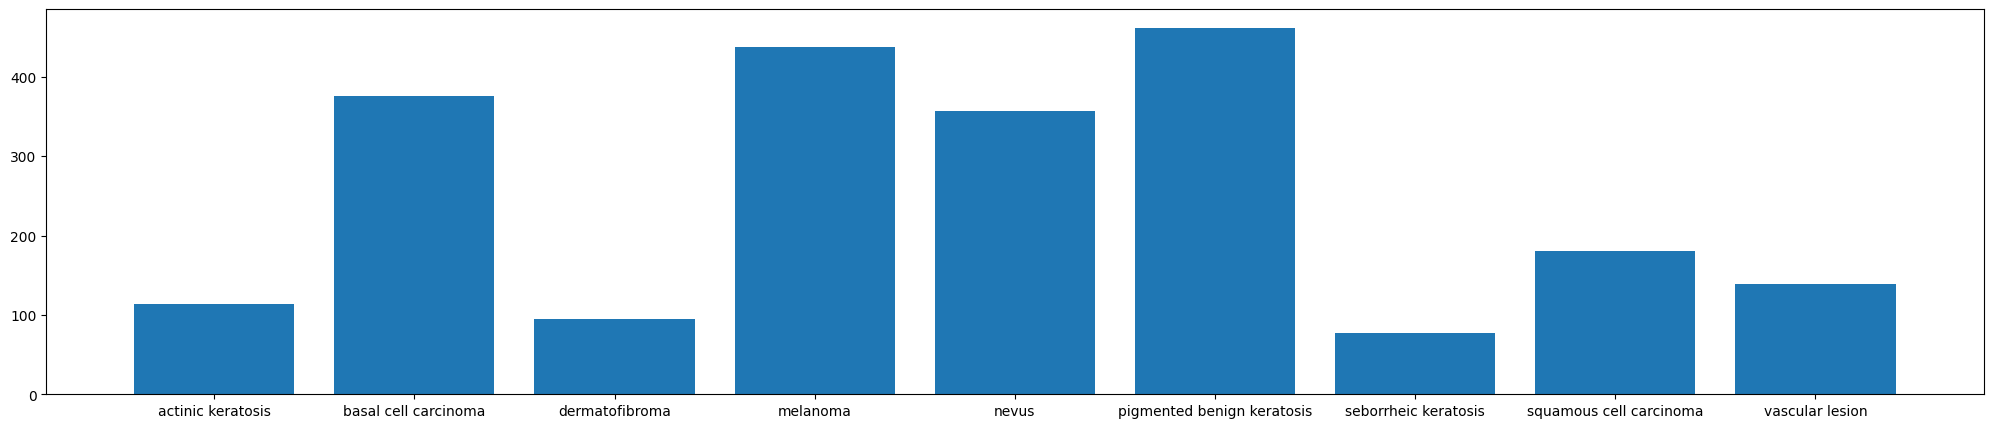

In [21]:
# Ploting the number of images in each Class
count = []
for name in class_names:
    count.append(len(list(data_dir_train.glob(name + "/*.jpg"))))
plt.figure(figsize=(25, 5))
plt.bar(class_names, count)

**Insights:**


1.   ***Seborrheic keratosi class has the least number of samples.***
2.   ***Pigmented Benign keratosis classes dominate the data in terms proportionate number of samples.***



In [23]:
# To add more samples across all classes so that none of the classes have very few samples we use Augmentor.
import Augmentor

path_to_training_dataset = str(data_dir_train) + "/"

# We are adding 500 samples per class to make sure that none of the classes are sparse.
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5791D7190>: 100%|██████████| 500/500 [00:36<00:00, 13.71 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE57BE8F670>: 100%|██████████| 500/500 [00:36<00:00, 13.74 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5782DD6C0>: 100%|██████████| 500/500 [00:26<00:00, 18.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE5791283A0>: 100%|██████████| 500/500 [01:52<00:00,  4.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2314x2067 at 0x7FE5790F6320>: 100%|██████████| 500/500 [02:08<00:00,  3.90 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5794C4AF0>: 100%|██████████| 500/500 [00:27<00:00, 18.09 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE579150640>: 100%|██████████| 500/500 [01:00<00:00,  8.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE578F2A530>: 100%|██████████| 500/500 [00:28<00:00, 17.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5789FB880>: 100%|██████████| 500/500 [00:29<00:00, 17.24 Samples/s]


<BarContainer object of 9 artists>

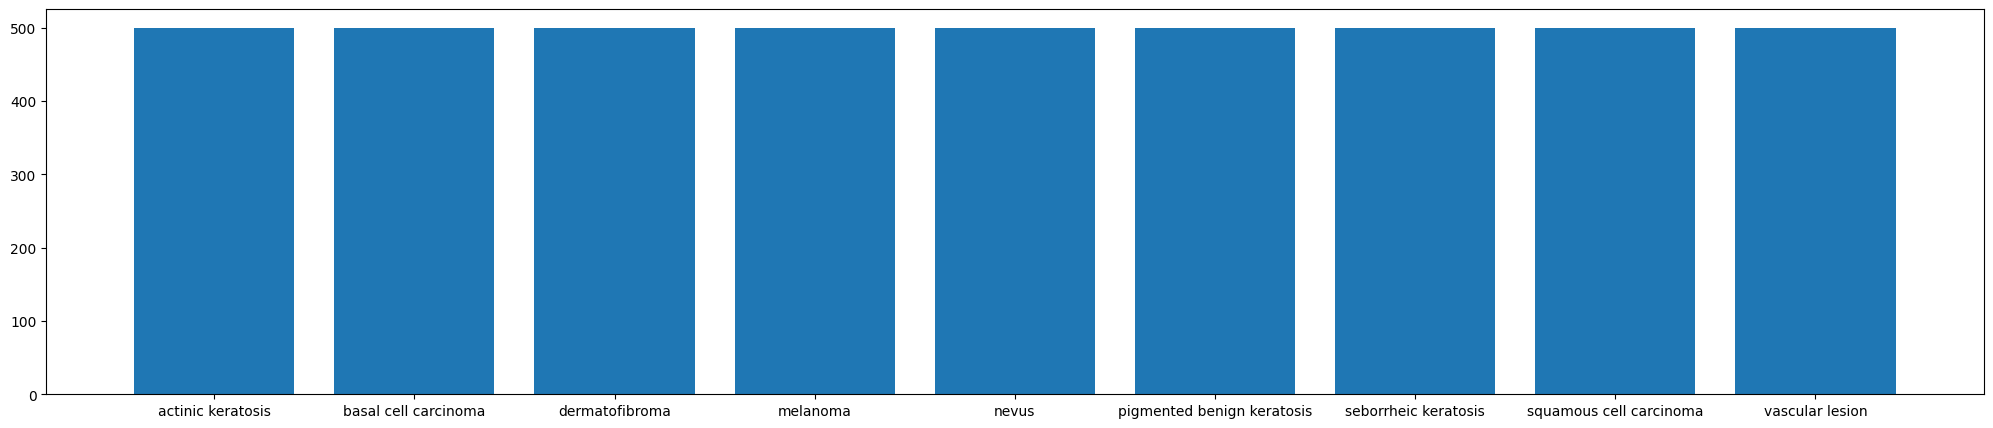

In [24]:
# Checking the distribution of data
count = []
for name in class_names:
    count.append(len(list(data_dir_train.glob(name + "*/output/*.jpg"))))
plt.figure(figsize=(25, 5))
plt.bar(class_names, count)

In [25]:
# Lets take a look at total count of augmented images.
image_count_train = len(list(data_dir_train.glob("*/output/*.jpg")))
print(image_count_train)

4500


In [26]:
from glob import glob

# Getting the path of new data
path_list_new = [
    x for x in glob(os.path.join(data_dir_train, "*", "output", "*.jpg"))
]
# Getting the list of names
lesion_list_new = [
    os.path.basename(os.path.dirname(os.path.dirname(y)))
    for y in glob(os.path.join(data_dir_train, "*", "output", "*.jpg"))
]
# Creating a dataframe
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [27]:
# Get Existing images in Dataframe
path_list = []
lesion_list = []
for name in class_names:
    for file in data_dir_train.glob(name + "/*.jpg"):
        path_list.append(str(file))
        lesion_list.append(name)

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(
    list(dataframe_dict_original.items()), columns=["Path", "Label"]
)

In [28]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=["Path", "Label"])
new_df = original_df.append(df2)

new_df["Label"].value_counts()

<ipython-input-28-c6392d5ab9e0>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**6. Model Building & training on the rectified class imbalance data :**

**Model 3**

In [32]:
model3 = Sequential(
    [
        layers.experimental.preprocessing.Rescaling(1.0 / 255),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(classes),
    ]
)

# Viewing the summary of model
model3.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [33]:
# Training the model for ~30 epochs
epochs = 30

history_2 = model3.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/30
169/169 [==============================] - 318s 2s/step - loss: 1.7998 - accuracy: 0.3082 - val_loss: 1.4361 - val_accuracy: 0.4588
Epoch 2/30
169/169 [==============================] - 229s 1s/step - loss: 1.4200 - accuracy: 0.4700 - val_loss: 1.4721 - val_accuracy: 0.4751
Epoch 3/30
169/169 [==============================] - 232s 1s/step - loss: 1.1942 - accuracy: 0.5590 - val_loss: 1.1127 - val_accuracy: 0.6028
Epoch 4/30
169/169 [==============================] - 227s 1s/step - loss: 0.9884 - accuracy: 0.6413 - val_loss: 0.9618 - val_accuracy: 0.6429
Epoch 5/30
169/169 [==============================] - 234s 1s/step - loss: 0.7872 - accuracy: 0.7175 - val_loss: 0.8777 - val_accuracy: 0.6934
Epoch 6/30
169/169 [==============================] - 237s 1s/step - loss: 0.6522 - accuracy: 0.7710 - val_loss: 0.7406 - val_accuracy: 0.7498
Epoch 7/30
169/169 [==============================] - 230s 1s/step - loss: 0.5171 - accuracy: 0.8207 - val_loss: 0.8299 - val_accuracy: 0.7439

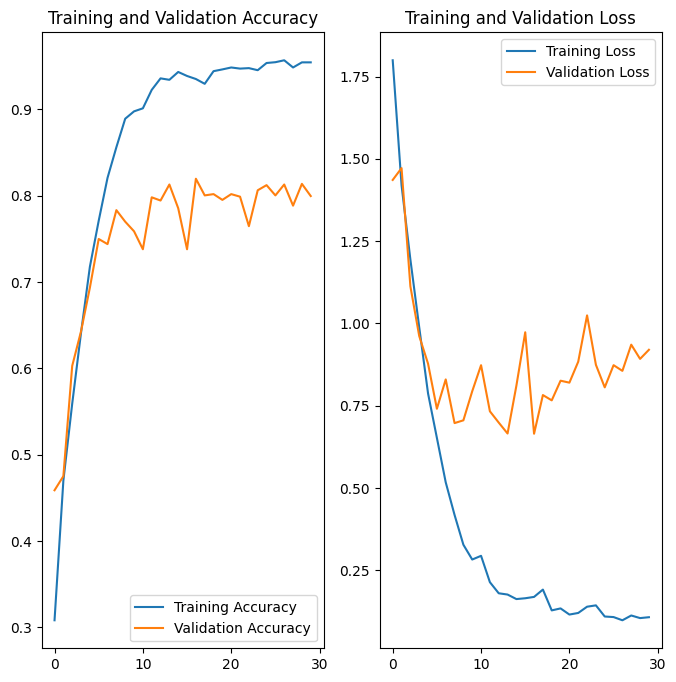

In [34]:
results(history_2)

Because to augmentation and class imbalance management, training and validation accuracy has enhanced dramatically. The model does not overfit. This model can serve as the final model.

**Training Accuracy:** 95.44 &
**Validation Accuracy:** 79.96